# Transit Light Curve analysis
We shall use a package called eleanor to extract light curve from TESS
See https://adina.feinste.in/eleanor/index.html for more information about the Eleanor package
+  "TESS Full Frame Images (FFIs) to extracted and systematics-corrected light curves for any given star observed by TESS"


In [1]:
pip install eleanor 

<b> The purpose of eleanor is to go from TESS Full Frame Images (FFIs) to extracted and systematics-corrected light curves for any given star observed by TESS. In its simplest form, eleanor takes a TIC ID, a Gaia source ID, or (RA, Dec) coordinates of a star observed by TESS and returns, as a single object, a light curve and accompanying target pixel data. </b>

In [3]:
help('tensorflow')

Help on package tensorflow:

NAME
    tensorflow

DESCRIPTION
    Top-level module of TensorFlow. By convention, we refer to this module as
    `tf` instead of `tensorflow`, following the common practice of importing
    TensorFlow via the command `import tensorflow as tf`.
    
    The primary function of this module is to import all of the public TensorFlow
    interfaces into a single place. The interfaces themselves are located in
    sub-modules, as described below.
    
    Note that the file `__init__.py` in the TensorFlow source code tree is actually
    only a placeholder to enable test cases to run. The TensorFlow build replaces
    this file with a file generated from [`api_template.__init__.py`](https://www.github.com/tensorflow/tensorflow/blob/master/tensorflow/api_template.__init__.py)

PACKAGE CONTENTS
    __internal__ (package)
    __operators__ (package)
    _api (package)
    audio (package)
    autodiff (package)
    autograph (package)
    bitwise (package)
    comp

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt
#sending tess and keppler telescopes out of the atmosphere so that the light from star is not distorted by earth's atmosphere 

## Get WASP-100's light curve from TESS data

In [5]:
# Based on https://adina.feinste.in/eleanor/#idocs_quickstart
star = eleanor.Source(name='WASP-100', sector=1) #name should be correct, tess divides sky into many sectors and remains on each sector for 21 days  
print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}' #gaia=spacecraft of esa
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))
# RA+ right ascention, dec= declination (space coordinates)

INFO: Found cached file ./mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file ./mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file ./mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]
Found TIC 38846515 (Gaia 4675352109659600000), with TESS magnitude 10.3157, RA 68.95970874999999, and Dec -64.02703694444445


C:\Users\pankh\anaconda3\lib\site-packages\eleanor\ffi.py:41: EleanorWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model", category=EleanorWarning)


In [6]:
# Do photometry to obtain the light curve
#Photometry is the science of the measurement of light
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=False, do_pca=True, regressors='corner')

C:\Users\pankh\anaconda3\lib\site-packages\eleanor\targetdata.py:368: UserWarning: The size postage stamp you are requesting falls off                 the edge of the postcard.
  warnings.warn("The size postage stamp you are requesting falls off \
C:\Users\pankh\anaconda3\lib\site-packages\eleanor\targetdata.py:370: UserWarning: WARNING: Your postage stamp may not be centered.
  warnings.warn("WARNING: Your postage stamp may not be centered.")


<IPython.core.display.Javascript object>


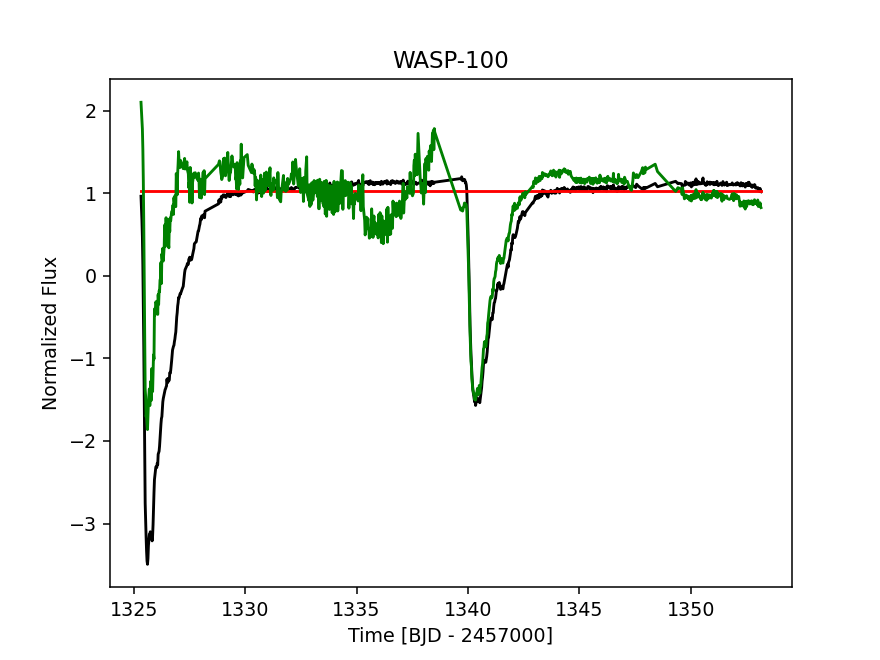

In [14]:
%matplotlib notebook 
#interactive notebook
#plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k') #0.06?
#Compute the median along the specified axis, while ignoring NaNs.Returns the median of the array elements.

plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g') #pca psf data?
#plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b') #corrections 
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]') 
plt.title('WASP-100');

## BoxLeastSquares to find period and transists and making periodograms
+ See https://docs.astropy.org/en/latest/timeseries/bls.html on BLS

<IPython.core.display.Javascript object>


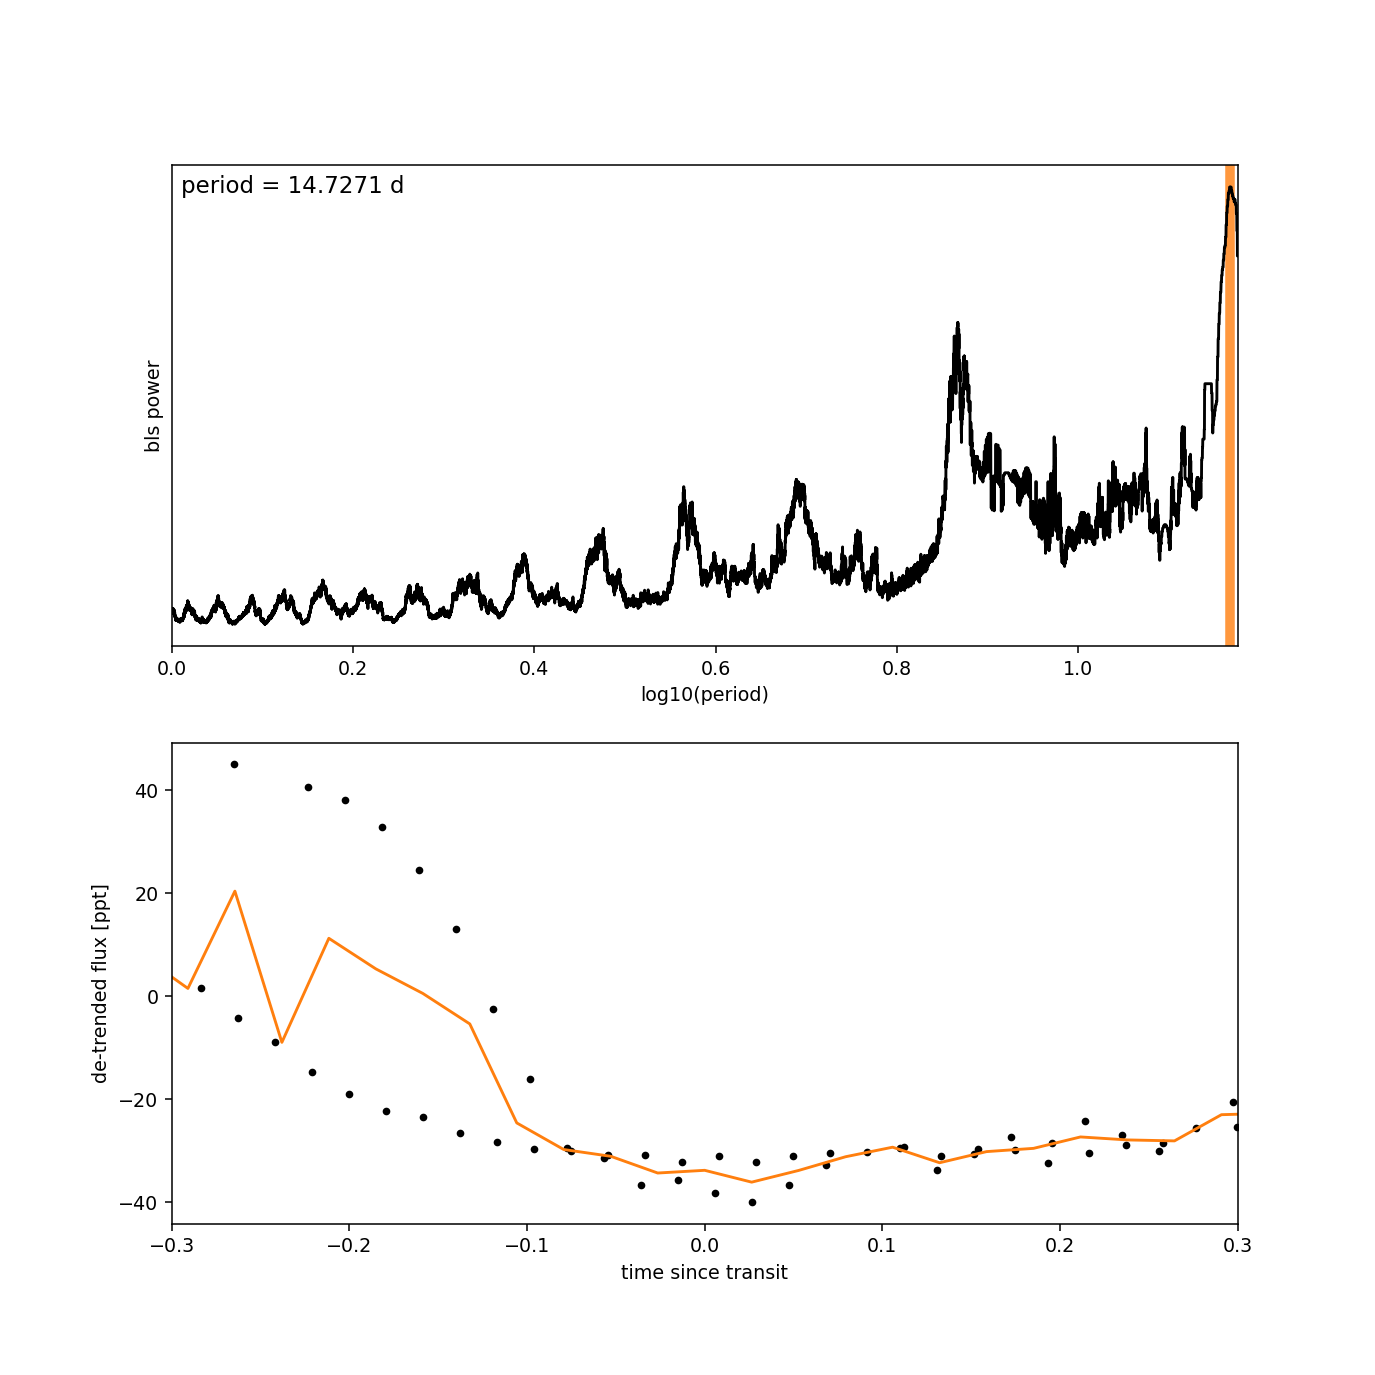

In [8]:
# Based on https://docs.exoplanet.codes/en/v0.2.1/tutorials/tess/
# See https://docs.astropy.org/en/latest/timeseries/bls.html on BLS

from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(data.time[q], data.pca_flux[q]) #pca= green signal above
bls_power = bls.power(period_grid, 0.1, oversample=20) #??

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index] 
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(data.time[q], bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit (folding all the signals to see if they are overlapping)
ax = axes[1]
x_fold = (data.time[q] - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], data.pca_flux[q][m], ".k")

# Overplot the phase binned light curve 
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=data.pca_flux[q])
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");
plt.show()

on folding the points are overlapping

## Let's create some artifical tranist light curves first

In [8]:
pip install pytransit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 11.6 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 11.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.6 MB/s eta 0:00:0031m11.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.9/870.9 KB 11.6 MB/s eta 0:00:0031m11.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 11.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 KB 11.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.2

In [2]:
pip install arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.1 MB/s eta 0:00:0031m10.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 11.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 KB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install celerite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 7.6 MB/s eta 0:00:009.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [34]:
from pytransit import QuadraticModel
times = np.linspace(0.85, 1.15,  100)
tm = QuadraticModel() 
tm.set_data(times)
k = 0.1 # k is the planet-star radius ratio
ldc = [0.3, 0.5]#0.3 .1# ldc is an ndarray containing the model-specific limb darkening coefficients 
t0 = 1 # t0 is the zero epoch
p = 2.1 # p is the orbital period
a = 3.2 # a is the scaled semi-major axis in uunits of stellar radius
i = 0.45*np.pi # i is the inclination
e = 0 #e is the eccentricity
w = 0 #w is the argument of periastron
flux = tm.evaluate(k, ldc, t0, p, a, i, e, w)

<IPython.core.display.Javascript object>


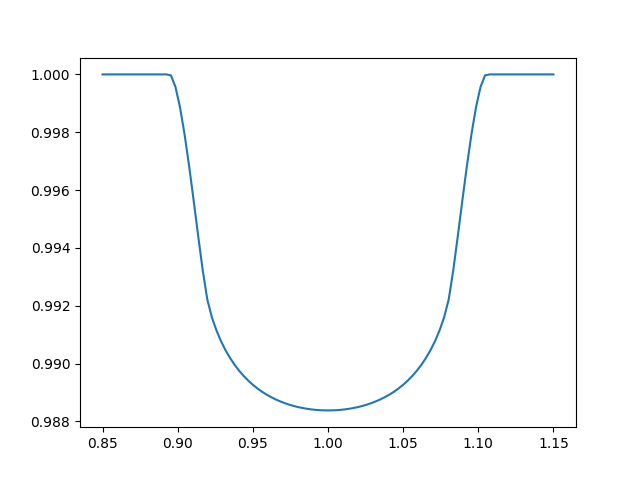

In [35]:
%matplotlib notebook
plt.plot(times,flux)
plt.show()


## Explore various parameter tweaks and its impact on the light curve

<IPython.core.display.Javascript object>


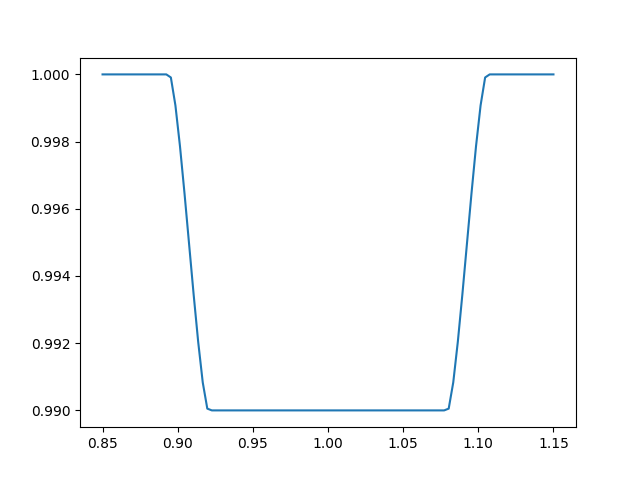

In [36]:
k = 0.1 # k is the planet-star radius ratio
ldc = [0, 0]#0.3 .1# ldc is an ndarray containing the model-specific limb darkening coefficients 
t0 = 1 # t0 is the zero epoch
p = 2.1 # p is the orbital period
a = 3.2 # a is the scaled semi-major axis in uunits of stellar radius
i = 0.45*np.pi # i is the inclination
e = 0 #e is the eccentricity
w = 0 #w is the argument of periastron
flux = tm.evaluate(k, ldc, t0, p, a, i, e, w)
plt.plot(times,flux)
plt.show()

In [37]:
# Based on https://github.com/hpparvi/PyTransit/blob/master/notebooks/001_simple_broadband_parameter_estimation.ipynb
from pytransit import TransitAnalysis
ta = TransitAnalysis(name='WASP-100', passbands='TESS', times=0.5*(bins[1:] + bins[:-1]), fluxes=(num / denom)/np.median(num/denom))
ta.print_parameters(1)

  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  1 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  2 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf]
  3 |G| b_1            U(a = 0.0, b = 1.0)                      [    0.00 ..      inf]
  4 |G| k2_1           U(a = 0.0004, b = 0.04000000000000001)   [    0.00 ..      inf]
  5 |G| secw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  6 |G| sesw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  7 |P| q1_TESS        U(a = 0, b = 1)                          [    0.00 ..     1.00]
  8 |P| q2_TESS        U(a = 0, b = 1)                          [    0.00 ..     1.00]
  9 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]


Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


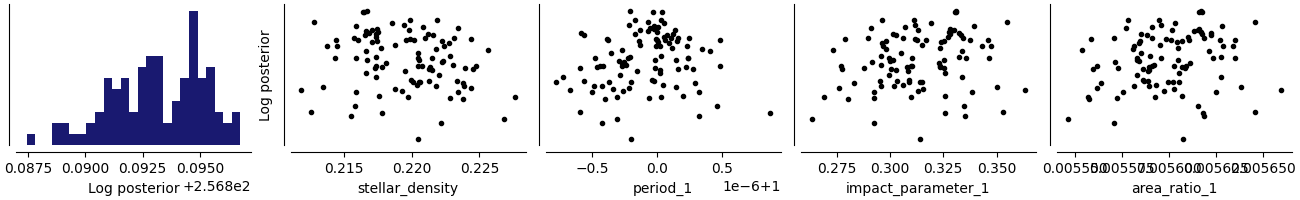

In [38]:
ta.optimize_global(niter=500, npop=100)


<IPython.core.display.Javascript object>


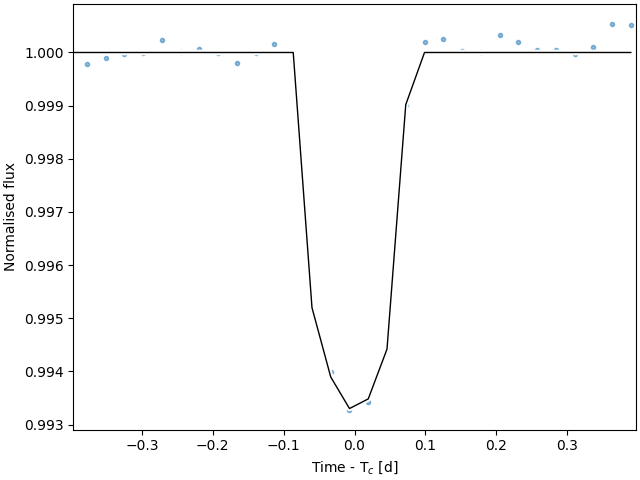

In [44]:
ta.plot_light_curves(method='fit');


In [45]:
ta.sample_mcmc(niter=2000, thin=20, repeats=3, save=False)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


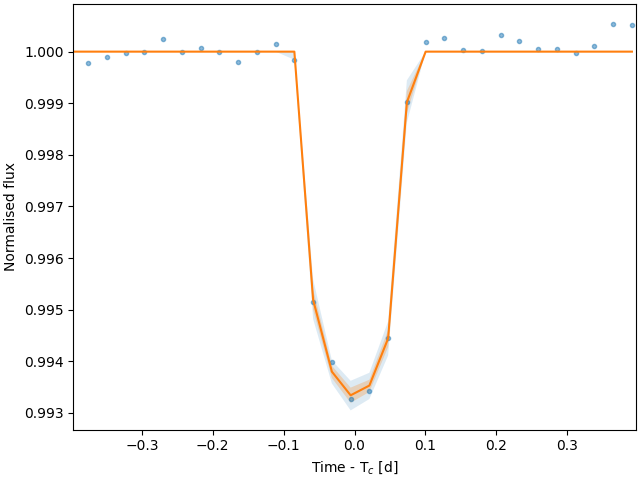

In [46]:

ta.plot_light_curves(method='posterior');


In [47]:
import corner
df = ta.posterior_samples()


corner(df.derived_parameters);


TypeError: 'module' object is not callable

# Lightkurve
See http://docs.lightkurve.org/quickstart.html

+ It can be used to download any light curve or pixel image data from TESS and Kepler

<b> WASP-100 </b>

In [3]:
pip install lightkurve --upgrade


Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt

In [6]:
search_result = lk.search_targetpixelfile('WASP-100')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,38846515,0.0
1,TESS Sector 01,2018,TESS-SPOC,1800,38846515,0.0
2,TESS Sector 02,2018,SPOC,120,38846515,0.0
3,TESS Sector 02,2018,TESS-SPOC,1800,38846515,0.0
4,TESS Sector 03,2018,SPOC,120,38846515,0.0
5,TESS Sector 03,2018,TESS-SPOC,1800,38846515,0.0
6,TESS Sector 04,2018,SPOC,120,38846515,0.0
7,TESS Sector 04,2018,TESS-SPOC,1800,38846515,0.0
8,TESS Sector 05,2018,SPOC,120,38846515,0.0


In [7]:
search_result[1]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TESS-SPOC,1800,38846515,0.0


In [9]:
tpf_file = search_result[1].download(quality_bitmask='default')
tpf_file

TessTargetPixelFile(TICID: 38846515)

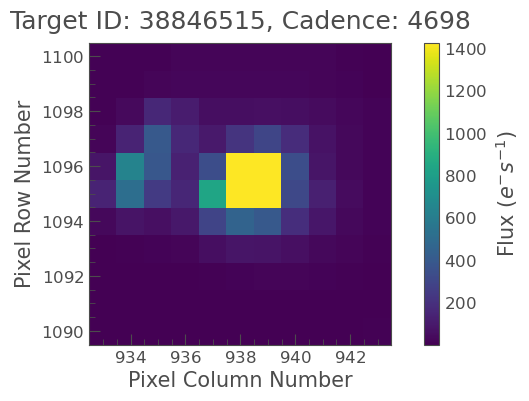

In [10]:
%matplotlib inline
tpf_file.plot();

In [11]:
tpf_file.get_header(ext=0)


SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    3 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-10-30'         / file creation date.                            
TSTART  =    1325.313499061224 / observation start time in BTJD                 
TSTOP   =    1353.167982726051 / observation stop time in BTJD                  
DATE-OBS= '2018-07-25T19:30:

In [12]:
tpf_file.get_header(ext=0)['Sector']

1

In [13]:
tpf_file.sector


1

In [14]:
tpf_file.mission

'TESS'

In [15]:
tpf_file.ra

68.9597092399964

In [23]:
tpf_file.time 

<Time object: scale='tdb' format='btjd' value=[1325.34474937 1325.36558298 1325.3864166  ... 1353.11589919 1353.13673265
 1353.15756611]>

In [17]:
tpf_file.time.utc.iso

array(['2018-07-25 20:15:17.162', '2018-07-25 20:45:17.186',
       '2018-07-25 21:15:17.211', ..., '2018-08-22 14:45:44.507',
       '2018-08-22 15:15:44.518', '2018-08-22 15:45:44.529'], dtype='<U23')

In [18]:
tpf_file.flux.shape

(1184, 11, 11)

In [19]:
tpf_file.flux
tpf_file.cadenceno

array([4698, 4699, 4700, ..., 6031, 6032, 6033])

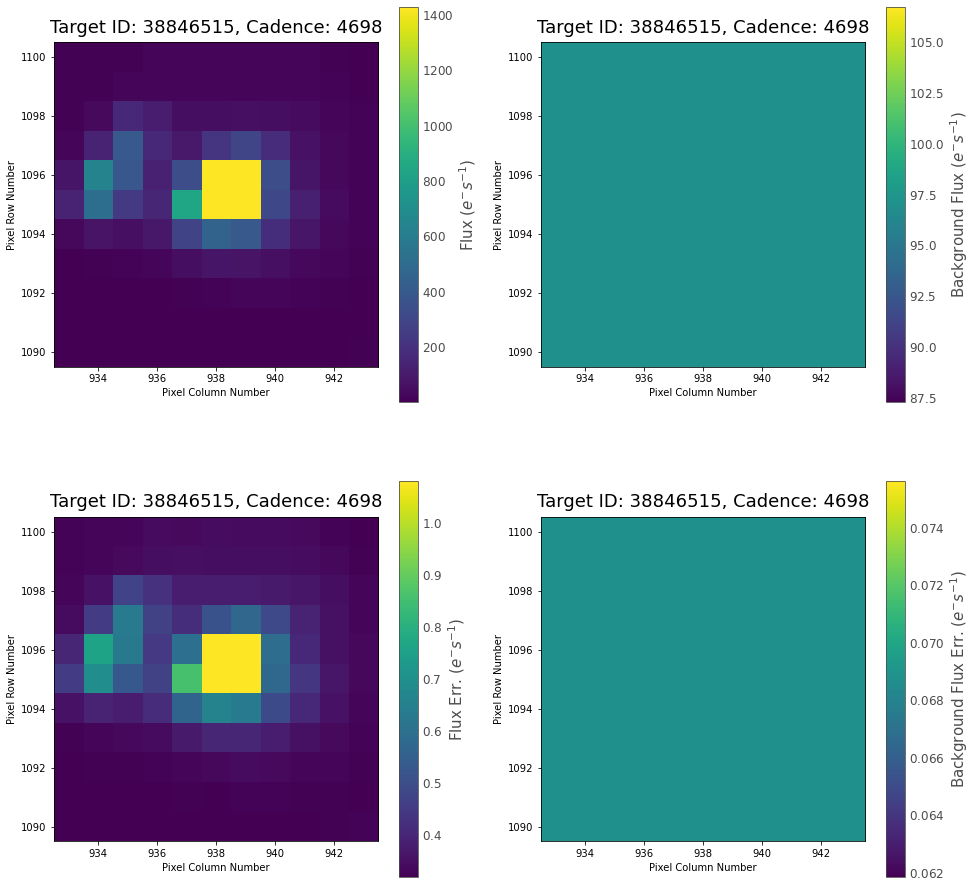

In [20]:
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(16,16))
tpf_file.plot(ax = axes[0,0], column = 'FLUX')
tpf_file.plot(ax = axes[0,1], column = 'FLUX_BKG')
tpf_file.plot(ax = axes[1,0], column = 'FLUX_ERR')
tpf_file.plot(ax = axes[1,1], column = 'FLUX_BKG_ERR');

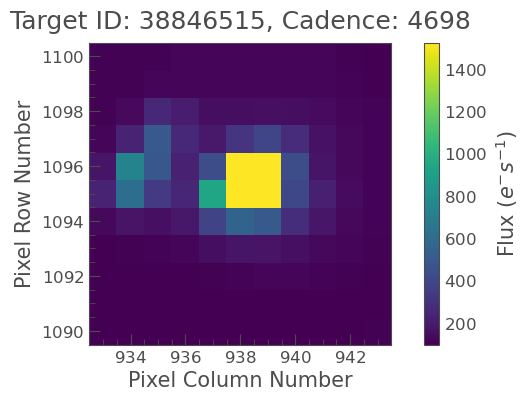

In [21]:
tpf_file.plot(bkg=True);

In [2]:
import lightkurve as lk

In [29]:
TIC = 'TIC 38846515'

In [30]:
sector_data = lk.search_lightcurve(TIC, author = 'SPOC')

In [31]:
sector_data 

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,38846515,0.0
1,TESS Sector 02,2018,SPOC,120,38846515,0.0
2,TESS Sector 03,2018,SPOC,120,38846515,0.0
3,TESS Sector 04,2018,SPOC,120,38846515,0.0
4,TESS Sector 05,2018,SPOC,120,38846515,0.0
5,TESS Sector 06,2018,SPOC,120,38846515,0.0
6,TESS Sector 07,2019,SPOC,120,38846515,0.0
7,TESS Sector 08,2019,SPOC,120,38846515,0.0
8,TESS Sector 09,2019,SPOC,120,38846515,0.0


In [33]:
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 1)

In [34]:
sector_data

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,38846515,0.0


In [35]:
lc= sector_data.download()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

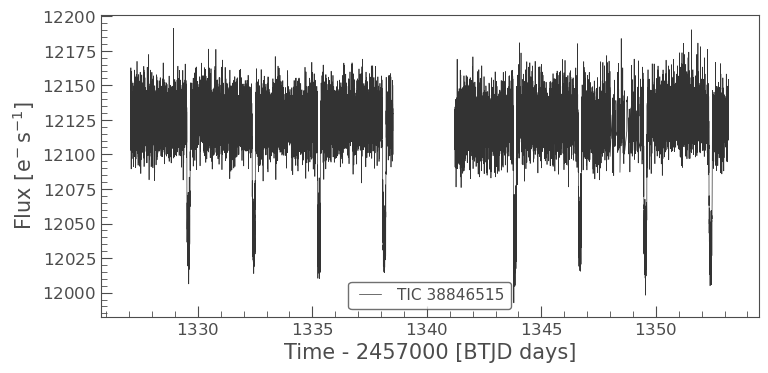

In [36]:
lc.plot()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

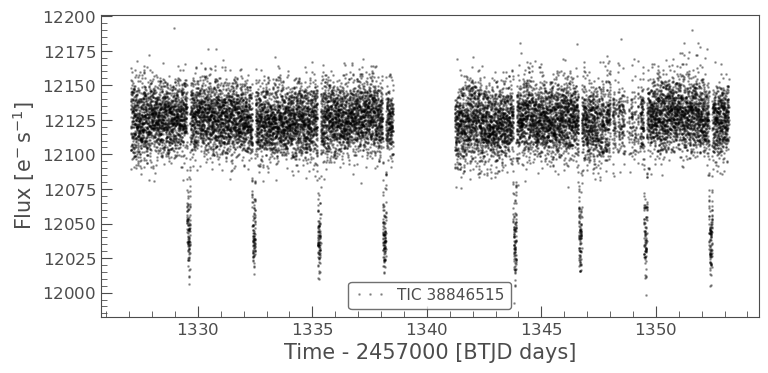

In [37]:
lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)

In [49]:
TIC_2 = 'TIC 38846515'

In [50]:
available_data_all = lk.search_lightcurve(TIC_2, author = 'SPOC')

In [51]:
available_data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,38846515,0.0
1,TESS Sector 02,2018,SPOC,120,38846515,0.0
2,TESS Sector 03,2018,SPOC,120,38846515,0.0
3,TESS Sector 04,2018,SPOC,120,38846515,0.0
4,TESS Sector 05,2018,SPOC,120,38846515,0.0
5,TESS Sector 06,2018,SPOC,120,38846515,0.0
6,TESS Sector 07,2019,SPOC,120,38846515,0.0
7,TESS Sector 08,2019,SPOC,120,38846515,0.0
8,TESS Sector 09,2019,SPOC,120,38846515,0.0


In [52]:
select_sectors = available_data_all[0:38]

In [53]:
lc_collection = select_sectors.download_all()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

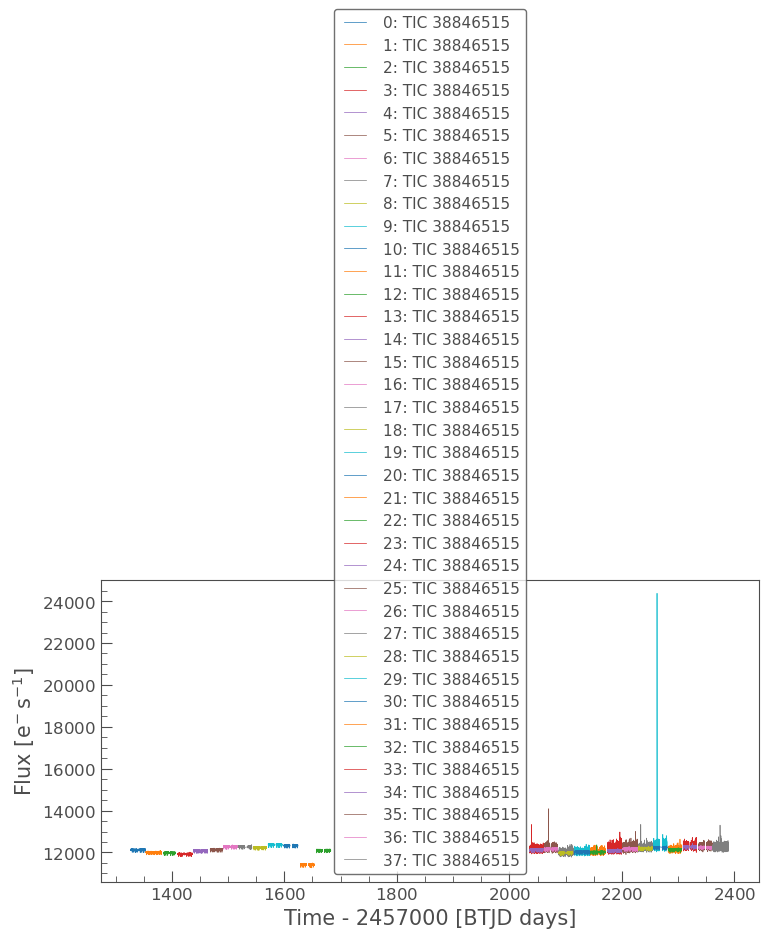

In [54]:
lc_collection.plot()

In [55]:
lc_collection_stitched = lc_collection.stitch()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

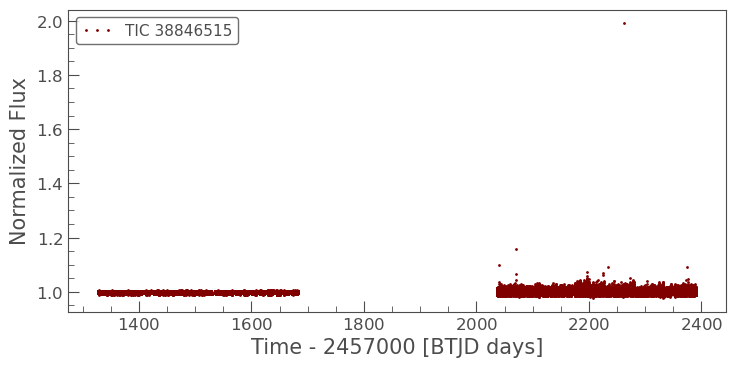

In [56]:
lc_collection_stitched.plot(lw = 0, marker = '.')

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

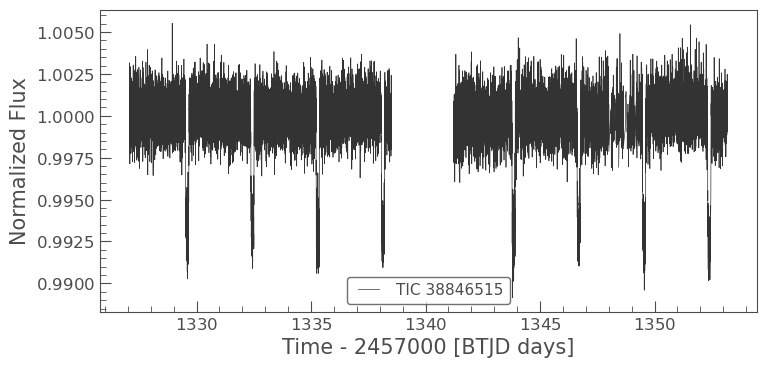

In [58]:
lc_noramlize = lc.normalize()
lc_noramlize.plot()